## This is a simple way for calculating and projecting LTV ( Life Time Value) for free-to-play platform/game, using a small portion of historical data. 


After reading and analyzing the data sample where we can see that our data contains: useer ID, game installation date, day of payment and amount of payment by user on a payment day.


The objective here is to:

a) Perform a little bit of the data engineering

b) Identify the best function for LTV projection

c) Find the polynom coefficients and the project values for LTV90 and LTV180 where LTV{N} forecast of LTV value for the day N

d) Considering that our player's lifetime is 180 days, we can calculate the coefficients K1, K3, K7, K30 and K180, where K{N} is the ratio between revenue by day N and LTV180, identifyig the bending point at which cumulative revenue generation slows down and we either need to attracat more users or need to stimulate existing users to purchase more.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import optimize
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('sq_data.csv')

In [3]:
print (data.shape)

(10, 4)


In [4]:
data.head()

,user,install_date,pay_date,sum
0,asdre5961,1/1/2018,1/1/2018,0.99
1,fdsfsd1895,1/1/2018,20/01/2018,4.95
2,rhuyn4346,3/1/2018,5/1/2018,0.99
3,asdre5961,1/1/2018,3/1/2018,3.97
4,rhuyn4346,3/1/2018,19/01/2018,0.99


In [5]:
data['install_date'] = pd.to_datetime(data['install_date'],dayfirst = True)
data['pay_date'] = pd.to_datetime(data['pay_date'], dayfirst = True)

In [6]:
data = data.sort_values('pay_date')

In [7]:
def get_cum_sum(date):
    return data['sum'].where(data['pay_date']<=date).sum()

data['cum_sum'] = data['pay_date'].map(lambda x: get_cum_sum(x))

In [8]:
def get_users_utd(date):
    return data['user'].where(data['install_date'] <=date).count()

data['users_n_utd'] = data['pay_date'].map(lambda x: get_users_utd(x))

In [9]:
data['ltv'] = data['cum_sum']/data['users_n_utd'].astype(float)

In [10]:
data['day'] = pd.to_timedelta(data['pay_date'] - data['install_date'].min()).dt.days + 1
data['day'] = data['day'].astype(int)

In [11]:
data.head(20)

,user,install_date,pay_date,sum,cum_sum,users_n_utd,ltv,day
0,asdre5961,2018-01-01,2018-01-01,0.99,0.99,5,0.198000,1
3,asdre5961,2018-01-01,2018-01-03,3.97,4.96,7,0.708571,3
2,rhuyn4346,2018-01-03,2018-01-05,0.99,5.95,7,0.850000,5
6,asdre5961,2018-01-01,2018-01-07,0.99,6.94,9,0.771111,7
8,fdsvf897,2018-01-10,2018-01-11,4.95,11.89,10,1.189000,11
5,frergr8715,2018-01-07,2018-01-12,0.99,12.88,10,1.288000,12
4,rhuyn4346,2018-01-03,2018-01-19,0.99,13.87,10,1.387000,19
1,fdsfsd1895,2018-01-01,2018-01-20,4.95,18.82,10,1.882000,20
9,asdre5961,2018-01-01,2018-01-30,0.99,19.81,10,1.981000,30
7,frergr8715,2018-01-07,2018-02-02,0.99,20.80,10,2.080000,33


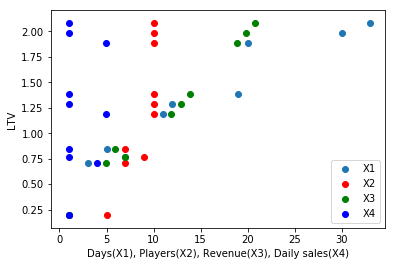

In [12]:
plt.scatter(data['day'], data['ltv'])
plt.scatter(data['users_n_utd'], data['ltv'], color='r')
plt.scatter(data['cum_sum'], data['ltv'], color='g')
plt.scatter(data['sum'], data['ltv'], color='b')
plt.xlabel('Days(X1), Players(X2), Revenue(X3), Daily sales(X4)')
plt.ylabel('LTV')
plt.legend(['X1', 'X2', 'X3', 'X4'])

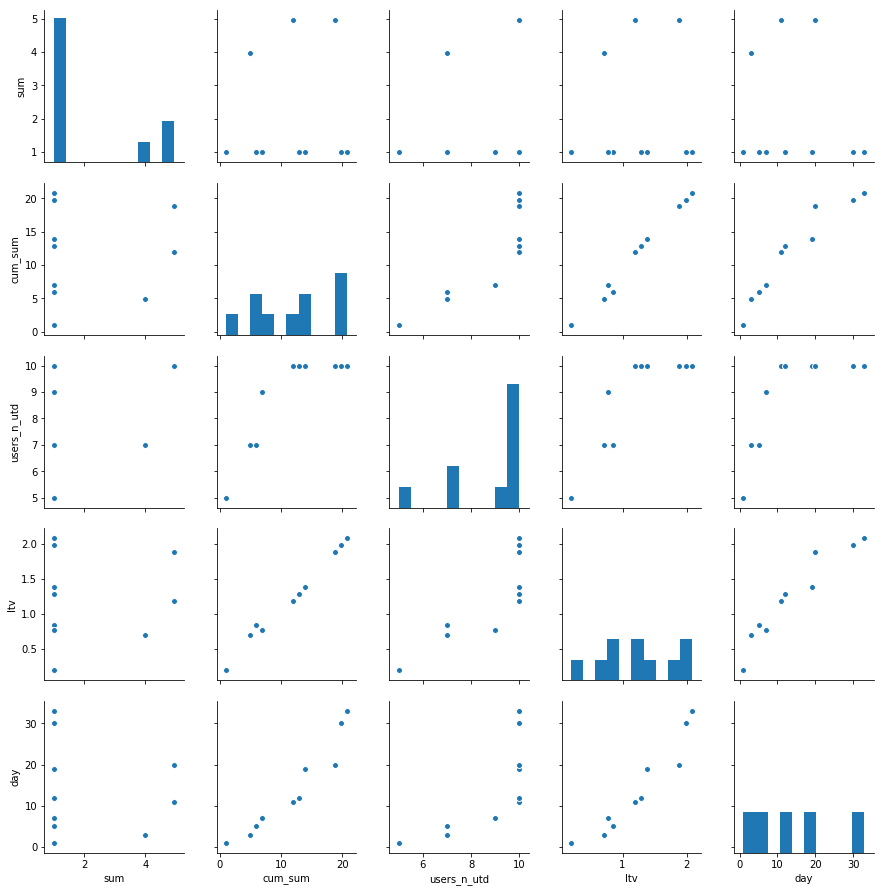

In [13]:
sns.pairplot(data)

In [14]:
ltv_data = data[['day','users_n_utd', 'cum_sum', 'ltv']]
X = ltv_data[['day', 'users_n_utd','cum_sum']]
y = ltv_data['ltv']

### From the calculation and data plots above we can see, that LTV in our case simply depends on two variables - cumulative sales and number of users - all that by days. 

So, I think there are two approaches one can assume:
##### Approach 1:
LTV by day has somewhat like a log-alike shape and we can predict it via optimizing the fit of the LTV value to the log-like function curve. This can be done with 2 assumptions: number of useers and cumulative sales are reaching saturation, which is somewhat true for the users once we look at the users over days plot and not so evident for the dily and thus cumulative sales. However, we can assume that the normal behaviour of the user on the platform shows that after certain amount of days user does not buy anything. Then the implementation one comes here for the **LTV prediction with optimize.curve_fit**


Text(0,0.5,'LTV')

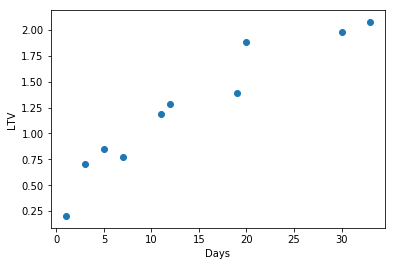

In [15]:
plt.scatter(data['day'], data['ltv'])
plt.xlabel('Days')
plt.ylabel('LTV')

In [16]:
# here is simple way for projectting LTV with the fit function for JUST LTV wishout really thinking what happening to the users and sales

X_l = X['day'].values 
Y_l = y.values

coefs_l, cov = optimize.curve_fit(lambda t,a,b: a+b*np.log(t),  X_l,  Y_l)

print (coefs_l)

def ltv_func(param):
    result = coefs_l[0] + coefs_l[1]*np.log(param)
    return result
    

ltv_90_180 = ltv_func([90., 180.])
ltv90 = round(ltv_90_180[0],2)
ltv180 = round(ltv_90_180[1],2)

print ("LTV by day 90: " + str(ltv90))
print ("LTV by day 180: " + str(ltv180))


[0.03441533 0.53589823]
LTV by day 90: 2.45
LTV by day 180: 2.82


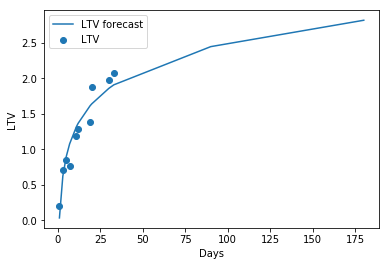

In [17]:
days = np.hstack([X_l, [90, 180]])
plt.scatter(X_l,y.values)
plt.plot(days,ltv_func(days.reshape(-1, 1)))
plt.xlabel('Days')
plt.ylabel('LTV')
plt.legend(['LTV forecast', 'LTV'])

In [18]:
k_days = [1, 3, 7, 30]
ks= []
for k in k_days:
    k_revenue = ltv_data['cum_sum'].loc[ltv_data['day'] == k].values[0] 
    coeff = ltv180/k_revenue
    ks.append(coeff)
    print ("K" + str(k) + ": " + str(round(coeff, 2)))
k180 = ltv180/(ltv180 * ltv_data['users_n_utd'].max())

K1: 2.85
K3: 0.57
K7: 0.41
K30: 0.14


Text(0,0.5,'KN')

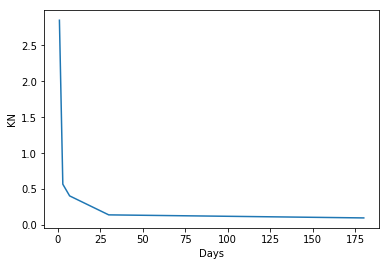

In [19]:
k_days.append(180)
ks.append(k180)
plt.plot(k_days, ks)
plt.xlabel('Days')
plt.ylabel('KN')

##### Approach 2
Alternative approach is to assume that we can **project separately the dynamics for users acquisition (installations) and also, the sales to each acquired user**. As the first assumption here we can think that out sales to each user stay more or less uniformly distributed along the user's lifetime. Maybe it's not quite typical for tha game-platform users, but still possible as we can observe from the day by day sales plots and the cumulative sales plot over the first 30 days.  Also, independent parameeters modeling can let us incorporate different assumtions about sales dynamics and users's aquisition dynamics as well as build forecasts for the different scenarios.

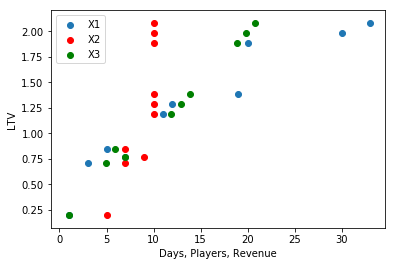

In [20]:
plt.scatter(X['day'].values,y)
plt.scatter(X['users_n_utd'].values,y, color = 'r')
plt.scatter(X['cum_sum'].values,y, color = 'g')
plt.xlabel('Days, Players, Revenue')
plt.ylabel('LTV')
plt.legend(['X1', 'X2', 'X3'])

Let's start with the users first. We see that by the end of the month we have reached saturation, but wee also can consider that we can fit the user's over day curve with log-like function and thus also tend to rach saturation.

Text(0,0.5,'Players')

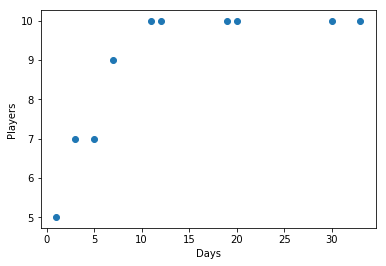

In [21]:
plt.scatter(X['day'].values,X['users_n_utd'].values)
plt.xlabel('Days')
plt.ylabel('Players')

In [22]:
X_u = X['day'].values 
Y_u = X['users_n_utd'].values

coefs_u, cov = optimize.curve_fit(lambda t,a,b: a+b*np.log(t),  X_u,  Y_u)

print (coefs_u)

[5.35053276 1.54168625]


In [23]:
def players_func(param):
    result = coefs_u[0] + coefs_u[1]*np.log(param)
    return result
    

users_90_180 = players_func([90., 180.])
u90 = int(round(users_90_180[0],0))
u180 = int(round(users_90_180[1],0))

print ("Users by day 90: " + str(u90))
print ("Users by day 180: " + str(u180))

Users by day 90: 12
Users by day 180: 13


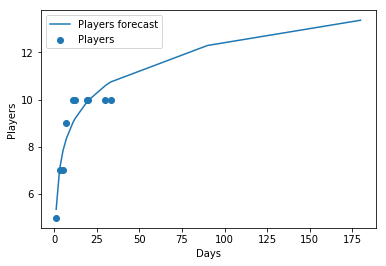

In [24]:
days = np.hstack([X['day'].values, [90, 180]])
plt.scatter(X['day'].values,X['users_n_utd'].values)
plt.plot(days,players_func(days.reshape(-1, 1)))
plt.xlabel('Days')
plt.ylabel('Players')
plt.legend(['Players forecast', 'Players'])

Now when we look at the sales dynamics, we can observe that there is no really any indication that users's stop making purchases. 

In [25]:
X_r = X['day'].values 
Y_r = X['cum_sum'].values

coefs_r, cov = optimize.curve_fit(lambda t,a,b: a+b*t,  X_r,  Y_r)

print (coefs_r)

[3.41873346 0.58668557]


In [26]:
def revenue_func(params):
    result = coefs_r[0] + coefs_r[1]*np.array(params)
    return result

revenue_90_180 = revenue_func([90., 180.])
r90 = round(revenue_90_180[0],2)
r180 = round(revenue_90_180[1],2)

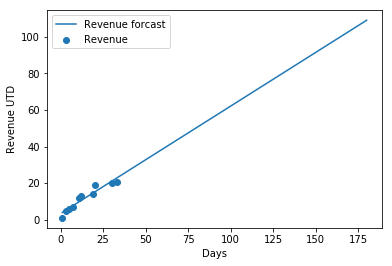

In [27]:
plt.scatter(X['day'].values,X['cum_sum'].values)
plt.plot(days,revenue_func(days.reshape(-1, 1)))
plt.xlabel('Days')
plt.ylabel('Revenue UTD')
plt.legend(['Revenue forcast', 'Revenue'])

In [28]:
def revenue_func(params):
    result = coefs_r[0] + coefs_r[1]*np.array(params)
    return result

revenue_90_180 = revenue_func([90., 180.])
r90 = round(revenue_90_180[0],2)
r180 = round(revenue_90_180[1],2)

Now the projection for LTV at day 90 and day 180 can be estimated as following

In [29]:
ltv90 = round(r90/u90, 2)
ltv180 = round(r180/u180, 2)

print ("LTV by day 90: " + str(ltv90))
print ("LTV by day 180: " + str(ltv180))

LTV by day 90: 4.68
LTV by day 180: 8.39


Text(0,0.5,'LTV')

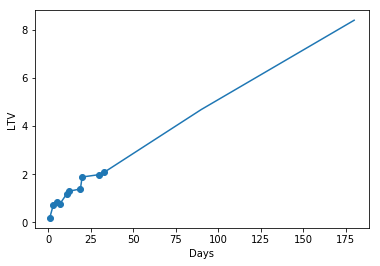

In [30]:
plt.scatter(X['day'].values,y)
ltv_p = np.hstack([y, [ltv90, ltv180]]) 
plt.plot(days, ltv_p)
plt.xlabel('Days')
plt.ylabel('LTV')

In [31]:
k_days = [1, 3, 7, 30]
k180 = round(ltv180/(ltv180 * u180), 2)
ks= []
for k in k_days:
    day_ltv = ltv_data['ltv'].loc[ltv_data['day'] == k].values[0]
    day_u = ltv_data['users_n_utd'].loc[ltv_data['day'] == k].values[0]
    K_revenue = (day_ltv*day_u)
    coeff = ltv180/K_revenue
    ks.append(coeff)
    print ("K" + str(k) + ": " + str(round(coeff, 2)))
print ("K180: " + str(k180)) 


K1: 8.47
K3: 1.69
K7: 1.21
K30: 0.42
K180: 0.08


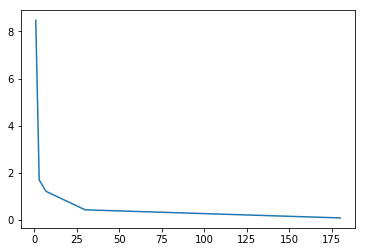

In [32]:
k_days.append(180)
ks.append(k180)
plt.plot(k_days, ks)

Also, using same approach as above we can try to model the saturation for revenue, but still project higher dinamics for the users' acquisition. Or, some saturation for both parameters, etc....thus building more optimistic or more pessimistic scenarios.